### 简介
CART树即分类回归树(classification and regression tree)，顾名思义，它即能用作分类任务又能用作回归任务，它的应用比较广泛，通常会用作集成学习的基分类器，总得来说，它与ID3/C4.5有如下不同：  

（1）它是一颗二叉树；   

（2）特征选择的方法不一样，CART分类树利用基尼系数做特征选择，CART回归树利用平方误差做特征选择；   

接下来，分别对CART分类树和回归树做介绍

### CART分类树

首先介绍特征选择方法，基尼系数：    

$$
Gini(p)=\sum_{k=1}^Kp_k(1-p_k)=1-\sum_{k=1}^Kp_k^2
$$   

所以，对于给定的样本集合$D$，其基尼指数：  

$$
Gini(D)=1-\sum_{k=1}^K(\frac{\mid C_k \mid}{\mid D \mid})^2
$$  

这里，$C_k$是$D$中属于第$k$类的样本子集，$K$是类的个数，由于CART树是二叉树，所以对于某特征$A$，判断其对分类标签的贡献时，只需要判断该特征是否等于某个取值$a$的情况，将当前数据集分割成$D_1$和$D_2$两部分：  

$$
D_1=\{(x,y)\in D\mid A(x)=a\},D_2=D-D_1
$$   

所以在特征$A(x)=a$的条件下，集合$D$的基尼指数可以定义为：  

$$
Gini(D,A,a)=\frac{\mid D_1 \mid}{\mid D \mid}Gini(D_1)+\frac{\mid D_2 \mid}{\mid D \mid}Gini(D_2),这里D_1=\{(x,y)\in D\mid A(x)=a\},D_2=D-D_1
$$  

#### 代码实现
接下来进行CART分类树的代码实现，这里与ID3/C4.5最大的不同就是每次对当前结点仅进行二分处理

In [1]:
"""
定义计算gini系数相关的函数,代码封装到ml_models.utils
"""
import numpy as np
def gini(x, sample_weight=None):
    """
    计算基尼系数 Gini(D)
    :param x:
    :param sample_weight:
    :return:
    """
    x_num = len(x)
    # 如果sample_weight为None设均设置一样
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    x_counter = {}
    weight_counter = {}
    # 统计各x取值出现的次数以及其对应的sample_weight列表
    for index in range(0, x_num):
        x_value = x[index]
        if x_counter.get(x_value) is None:
            x_counter[x_value] = 0
            weight_counter[x_value] = []
        x_counter[x_value] += 1
        weight_counter[x_value].append(sample_weight[index])

    # 计算gini系数
    gini_value = 1.0
    for key, value in x_counter.items():
        p_i = 1.0 * value * np.mean(weight_counter.get(key)) / x_num
        gini_value -= p_i * p_i
    return gini_value


def cond_gini(x, y, sample_weight=None):
    """
    计算条件gini系数:Gini(y,x)
    """
    x = np.asarray(x)
    y = np.asarray(y)
    # x中元素个数
    x_num = len(x)
    # 如果sample_weight为None设均设置一样
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    # 计算
    gini_value = .0
    for x_value in set(x):
        x_index = np.where(x == x_value)
        new_x = x[x_index]
        new_y = y[x_index]
        new_sample_weight = sample_weight[x_index]
        p_i = 1.0 * len(new_x) / x_num
        gini_value += p_i * gini(new_y, new_sample_weight)
    return gini_value


def gini_gain(x, y, sample_weight=None):
    """
    gini值的增益
    """
    x_num = len(x)
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    return gini(y, sample_weight) - cond_gini(x, y, sample_weight)

In [2]:
import os
os.chdir('../')
from ml_models import utils
from ml_models.wrapper_models import DataBinWrapper
"""
CART分类树的实现，代码封装到ml_models.tree模块
"""
class CARTClassifier(object):
    class Node(object):
        """
        树节点，用于存储节点信息以及关联子节点
        """

        def __init__(self, feature_index: int = None, feature_value=None, target_distribute: dict = None,
                     weight_distribute: dict = None,
                     left_child_node=None, right_child_node=None, num_sample: int = None):
            """
            :param feature_index: 特征id
            :param feature_value: 特征取值
            :param target_distribute: 目标分布
            :param weight_distribute:权重分布
            :param left_child_node: 左孩子结点
            :param right_child_node: 右孩子结点
            :param num_sample:样本量
            """
            self.feature_index = feature_index
            self.feature_value = feature_value
            self.target_distribute = target_distribute
            self.weight_distribute = weight_distribute
            self.left_child_node = left_child_node
            self.right_child_node = right_child_node
            self.num_sample = num_sample

    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_impurity_decrease=0, max_bins=10):
        """
        :param criterion:划分标准，默认为gini,另外entropy表示用信息增益比
        :param max_depth:树的最大深度
        :param min_samples_split:当对一个内部结点划分时，要求该结点上的最小样本数，默认为2
        :param min_samples_leaf:设置叶子结点上的最小样本数，默认为1
        :param min_impurity_decrease:打算划分一个内部结点时，只有当划分后不纯度(可以用criterion参数指定的度量来描述)减少值不小于该参数指定的值，才会对该结点进行划分，默认值为0
        """
        self.criterion = criterion
        if criterion == 'gini':
            self.criterion_func = utils.gini_gain
        else:
            self.criterion_func = utils.info_gain_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease

        self.root_node: self.Node = None
        self.dbw = DataBinWrapper(max_bins=max_bins)

    def _build_tree(self, current_depth, current_node: Node, x, y, sample_weight):
        """
        递归进行特征选择，构建树
        :param x:
        :param y:
        :param sample_weight:
        :return:
        """
        rows, cols = x.shape
        # 计算y分布以及其权重分布
        target_distribute = {}
        weight_distribute = {}
        for index, tmp_value in enumerate(y):
            if tmp_value not in target_distribute:
                target_distribute[tmp_value] = 0.0
                weight_distribute[tmp_value] = []
            target_distribute[tmp_value] += 1.0
            weight_distribute[tmp_value].append(sample_weight[index])
        for key, value in target_distribute.items():
            target_distribute[key] = value / rows
            weight_distribute[key] = np.mean(weight_distribute[key])
        current_node.target_distribute = target_distribute
        current_node.weight_distribute = weight_distribute
        current_node.num_sample = rows
        # 判断停止切分的条件

        if len(target_distribute) <= 1:
            return

        if rows < self.min_samples_split:
            return

        if self.max_depth is not None and current_depth > self.max_depth:
            return

        # 寻找最佳的特征以及取值
        best_index = None
        best_index_value = None
        best_criterion_value = 0
        for index in range(0, cols):
            for index_value in set(x[:, index]):
                criterion_value = self.criterion_func((x[:, index] == index_value).astype(int), y, sample_weight)
                if criterion_value > best_criterion_value:
                    best_criterion_value = criterion_value
                    best_index = index
                    best_index_value = index_value

        # 如果criterion_value减少不够则停止
        if best_index is None:
            return
        if best_criterion_value <= self.min_impurity_decrease:
            return
        # 切分
        current_node.feature_index = best_index
        current_node.feature_value = best_index_value
        selected_x = x[:, best_index]

        # 创建左孩子结点
        left_selected_index = np.where(selected_x == best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(left_selected_index[0]) >= self.min_samples_leaf:
            left_child_node = self.Node()
            current_node.left_child_node = left_child_node
            self._build_tree(current_depth + 1, left_child_node, x[left_selected_index], y[left_selected_index],
                             sample_weight[left_selected_index])
        # 创建右孩子结点
        right_selected_index = np.where(selected_x != best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(right_selected_index[0]) >= self.min_samples_leaf:
            right_child_node = self.Node()
            current_node.right_child_node = right_child_node
            self._build_tree(current_depth + 1, right_child_node, x[right_selected_index], y[right_selected_index],
                             sample_weight[right_selected_index])

    def fit(self, x, y, sample_weight=None):
        # check sample_weight
        n_sample = x.shape[0]
        if sample_weight is None:
            sample_weight = np.asarray([1.0] * n_sample)
        # check sample_weight
        if len(sample_weight) != n_sample:
            raise Exception('sample_weight size error:', len(sample_weight))

        # 构建空的根节点
        self.root_node = self.Node()

        # 对x分箱
        self.dbw.fit(x)

        # 递归构建树
        self._build_tree(1, self.root_node, self.dbw.transform(x), y, sample_weight)

    # 检索叶子节点的结果
    def _search_node(self, current_node: Node, x, class_num):
        if current_node.left_child_node is not None and x[current_node.feature_index] == current_node.feature_value:
            return self._search_node(current_node.left_child_node, x, class_num)
        elif current_node.right_child_node is not None and x[current_node.feature_index] != current_node.feature_value:
            return self._search_node(current_node.right_child_node, x, class_num)
        else:
            result = []
            total_value = 0.0
            for index in range(0, class_num):
                value = current_node.target_distribute.get(index, 0) * current_node.weight_distribute.get(index, 1.0)
                result.append(value)
                total_value += value
            # 归一化
            for index in range(0, class_num):
                result[index] = result[index] / total_value
            return result

    def predict_proba(self, x):
        # 计算结果概率分布
        x = self.dbw.transform(x)
        rows = x.shape[0]
        results = []
        class_num = len(self.root_node.target_distribute)
        for row in range(0, rows):
            results.append(self._search_node(self.root_node, x[row], class_num))
        return np.asarray(results)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def _prune_node(self, current_node: Node, alpha):
        # 如果有子结点,先对子结点部分剪枝
        if current_node.left_child_node is not None:
            self._prune_node(current_node.left_child_node, alpha)
        if current_node.right_child_node is not None:
            self._prune_node(current_node.right_child_node, alpha)
        # 再尝试对当前结点剪枝
        if current_node.left_child_node is not None or current_node.right_child_node is not None:
            # 避免跳层剪枝
            for child_node in [current_node.left_child_node, current_node.right_child_node]:
                # 当前剪枝的层必须是叶子结点的层
                if child_node.left_child_node is not None or child_node.right_child_node is not None:
                    return
            # 计算剪枝的前的损失值
            pre_prune_value = alpha * 2
            for child_node in [current_node.left_child_node, current_node.right_child_node]:
                for key, value in child_node.target_distribute.items():
                    pre_prune_value += -1 * child_node.num_sample * value * np.log(
                        value) * child_node.weight_distribute.get(key, 1.0)
            # 计算剪枝后的损失值
            after_prune_value = alpha
            for key, value in current_node.target_distribute.items():
                after_prune_value += -1 * current_node.num_sample * value * np.log(
                    value) * current_node.weight_distribute.get(key, 1.0)

            if after_prune_value <= pre_prune_value:
                # 剪枝操作
                current_node.left_child_node = None
                current_node.right_child_node = None
                current_node.feature_index = None
                current_node.feature_value = None

    def prune(self, alpha=0.01):
        """
        决策树剪枝 C(T)+alpha*|T|
        :param alpha:
        :return:
        """
        # 递归剪枝
        self._prune_node(self.root_node, alpha)

In [3]:
#造伪数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

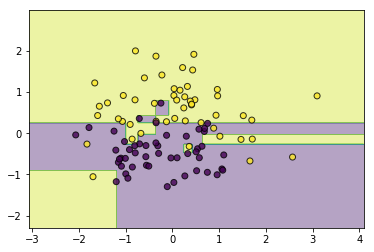

In [4]:
#训练并查看效果
tree = CARTClassifier()
tree.fit(data, target)
utils.plot_decision_function(data, target, tree)

一样的，如果不加以限制，同样会存在过拟合现象，所以可以剪枝...

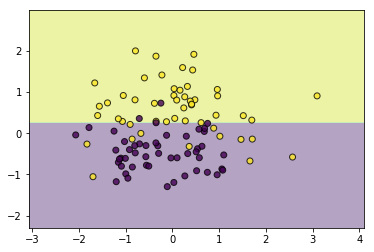

In [5]:
#剪枝
tree.prune(5)
utils.plot_decision_function(data, target, tree)

### CART回归树
回归树的特征选择是使用的平方误差，即选择一个特征$j$和一个取值$s$,将训练集按$X^j\leq s$和$X^j>s$分为两部分，寻找使这两部分的误差平方之和下降最多的$j,s$，这个过程可以描述如下：  

$$
\min_{j,s}[\min_{c_1}\sum_{x_i\in R_1(j,s)}(y_i-c_1)^2+\min_{c_2}\sum_{x_i\in R_2(j,s)}(y_i-c_2)^2]
$$    

这里$R_1(j,s)=\{x\mid x^j\leq s\},R_2(j,s)=\{x\mid x^j> s\},c_1=ave(y_i\mid x_i\in R_1(j,s)),c_2=ave(y_i\mid x_i\in R_2(j,s))$  

代码实现：  

In [6]:
"""
平方误差相关函数，封装到ml_models.utils
"""
def square_error(x, sample_weight=None):
    """
    平方误差
    :param x:
    :param sample_weight:
    :return:
    """
    x = np.asarray(x)
    x_mean = np.mean(x)
    x_num = len(x)
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    error = 0.0
    for index in range(0, x_num):
        error += (x[index] - x_mean) * (x[index] - x_mean) * sample_weight[index]
    return error


def cond_square_error(x, y, sample_weight=None):
    """
    计算按x分组的y的误差值
    :param x:
    :param y:
    :param sample_weight:
    :return:
    """
    x = np.asarray(x)
    y = np.asarray(y)
    # x中元素个数
    x_num = len(x)
    # 如果sample_weight为None设均设置一样
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    # 计算
    error = .0
    for x_value in set(x):
        x_index = np.where(x == x_value)
        new_y = y[x_index]
        new_sample_weight = sample_weight[x_index]
        error += square_error(new_y, new_sample_weight)
    return error


def square_error_gain(x, y, sample_weight=None):
    """
    平方误差带来的增益值
    :param x:
    :param y:
    :param sample_weight:
    :return:
    """
    x_num = len(x)
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    return square_error(y, sample_weight) - cond_square_error(x, y, sample_weight)

In [7]:
"""
CART回归树实现，封装到ml_models.tree
"""
class CARTRegressor(object):
    class Node(object):
        """
        树节点，用于存储节点信息以及关联子节点
        """

        def __init__(self, feature_index: int = None, feature_value=None, y_hat=None, square_error=None,
                     left_child_node=None, right_child_node=None, num_sample: int = None):
            """
            :param feature_index: 特征id
            :param feature_value: 特征取值
            :param y_hat: 预测值
            :param square_error: 当前结点的平方误差
            :param left_child_node: 左孩子结点
            :param right_child_node: 右孩子结点
            :param num_sample:样本量
            """
            self.feature_index = feature_index
            self.feature_value = feature_value
            self.y_hat = y_hat
            self.square_error = square_error
            self.left_child_node = left_child_node
            self.right_child_node = right_child_node
            self.num_sample = num_sample

    def __init__(self, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_std=1e-3,
                 min_impurity_decrease=0, max_bins=10):
        """
        :param criterion:划分标准，目前仅有平方误差
        :param max_depth:树的最大深度
        :param min_samples_split:当对一个内部结点划分时，要求该结点上的最小样本数，默认为2
        :param min_std:最小的标准差
        :param min_samples_leaf:设置叶子结点上的最小样本数，默认为1
        :param min_impurity_decrease:打算划分一个内部结点时，只有当划分后不纯度(可以用criterion参数指定的度量来描述)减少值不小于该参数指定的值，才会对该结点进行划分，默认值为0
        """
        self.criterion = criterion
        if criterion == 'mse':
            self.criterion_func = utils.square_error_gain
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_std = min_std
        self.min_impurity_decrease = min_impurity_decrease

        self.root_node: self.Node = None
        self.dbw = DataBinWrapper(max_bins=max_bins)

    def _build_tree(self, current_depth, current_node: Node, x, y, sample_weight):
        """
        递归进行特征选择，构建树
        :param x:
        :param y:
        :param sample_weight:
        :return:
        """
        rows, cols = x.shape
        # 计算当前y的加权平均值
        current_node.y_hat = np.dot(sample_weight / np.sum(sample_weight), y)
        current_node.num_sample = rows
        # 判断停止切分的条件
        current_node.square_error = np.dot(y - np.mean(y), y - np.mean(y))
        if np.sqrt(current_node.square_error / rows) <= self.min_std:
            return

        if rows < self.min_samples_split:
            return

        if self.max_depth is not None and current_depth > self.max_depth:
            return

        # 寻找最佳的特征以及取值
        best_index = None
        best_index_value = None
        best_criterion_value = 0
        for index in range(0, cols):
            for index_value in sorted(set(x[:, index])):
                criterion_value = self.criterion_func((x[:, index] <= index_value).astype(int), y, sample_weight)
                if criterion_value > best_criterion_value:
                    best_criterion_value = criterion_value
                    best_index = index
                    best_index_value = index_value

        # 如果criterion_value减少不够则停止
        if best_index is None:
            return
        if best_criterion_value <= self.min_impurity_decrease:
            return
        # 切分
        current_node.feature_index = best_index
        current_node.feature_value = best_index_value
        selected_x = x[:, best_index]

        # 创建左孩子结点
        left_selected_index = np.where(selected_x <= best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(left_selected_index[0]) >= self.min_samples_leaf:
            left_child_node = self.Node()
            current_node.left_child_node = left_child_node
            self._build_tree(current_depth + 1, left_child_node, x[left_selected_index], y[left_selected_index],
                             sample_weight[left_selected_index])
        # 创建右孩子结点
        right_selected_index = np.where(selected_x > best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(right_selected_index[0]) >= self.min_samples_leaf:
            right_child_node = self.Node()
            current_node.right_child_node = right_child_node
            self._build_tree(current_depth + 1, right_child_node, x[right_selected_index], y[right_selected_index],
                             sample_weight[right_selected_index])

    def fit(self, x, y, sample_weight=None):
        # check sample_weight
        n_sample = x.shape[0]
        if sample_weight is None:
            sample_weight = np.asarray([1.0] * n_sample)
        # check sample_weight
        if len(sample_weight) != n_sample:
            raise Exception('sample_weight size error:', len(sample_weight))

        # 构建空的根节点
        self.root_node = self.Node()

        # 对x分箱
        self.dbw.fit(x)

        # 递归构建树
        self._build_tree(1, self.root_node, self.dbw.transform(x), y, sample_weight)

    # 检索叶子节点的结果
    def _search_node(self, current_node: Node, x):
        if current_node.left_child_node is not None and x[current_node.feature_index] <= current_node.feature_value:
            return self._search_node(current_node.left_child_node, x)
        elif current_node.right_child_node is not None and x[current_node.feature_index] > current_node.feature_value:
            return self._search_node(current_node.right_child_node, x)
        else:
            return current_node.y_hat

    def predict(self, x):
        # 计算结果概率分布
        x = self.dbw.transform(x)
        rows = x.shape[0]
        results = []
        for row in range(0, rows):
            results.append(self._search_node(self.root_node, x[row]))
        return np.asarray(results)

    def _prune_node(self, current_node: Node, alpha):
        # 如果有子结点,先对子结点部分剪枝
        if current_node.left_child_node is not None:
            self._prune_node(current_node.left_child_node, alpha)
        if current_node.right_child_node is not None:
            self._prune_node(current_node.right_child_node, alpha)
        # 再尝试对当前结点剪枝
        if current_node.left_child_node is not None or current_node.right_child_node is not None:
            # 避免跳层剪枝
            for child_node in [current_node.left_child_node, current_node.right_child_node]:
                # 当前剪枝的层必须是叶子结点的层
                if child_node.left_child_node is not None or child_node.right_child_node is not None:
                    return
            # 计算剪枝的前的损失值
            pre_prune_value = alpha * 2 + \
                              (0.0 if current_node.left_child_node.square_error is None else current_node.left_child_node.square_error) + \
                              (0.0 if current_node.right_child_node.square_error is None else current_node.right_child_node.square_error)
            # 计算剪枝后的损失值
            after_prune_value = alpha + current_node.square_error

            if after_prune_value <= pre_prune_value:
                # 剪枝操作
                current_node.left_child_node = None
                current_node.right_child_node = None
                current_node.feature_index = None
                current_node.feature_value = None
                current_node.square_error = None

    def prune(self, alpha=0.01):
        """
        决策树剪枝 C(T)+alpha*|T|
        :param alpha:
        :return:
        """
        # 递归剪枝
        self._prune_node(self.root_node, alpha)

In [8]:
#构造数据
data = np.linspace(1, 10, num=100)
target = np.sin(data) + np.random.random(size=100)#添加噪声
data = data.reshape((-1, 1))

In [9]:
tree = CARTRegressor(max_bins=50)
tree.fit(data, target)

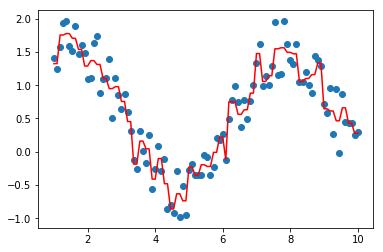

In [10]:
import matplotlib.pyplot as plt
plt.scatter(data, target)
plt.plot(data, tree.predict(data), color='r')

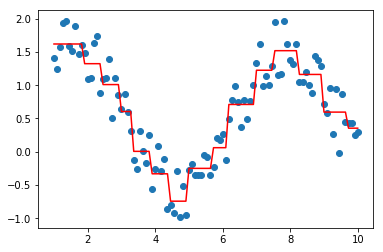

In [11]:
#剪枝
tree.prune(1)
plt.scatter(data, target)
plt.plot(data, tree.predict(data), color='r')